<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 350735 to 352413
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Global_active_power    50000 non-null  object 
 1   Global_reactive_power  50000 non-null  object 
 2   Voltage                50000 non-null  object 
 3   Global_intensity       50000 non-null  object 
 4   Sub_metering_1         50000 non-null  object 
 5   Sub_metering_2         50000 non-null  object 
 6   Sub_metering_3         49797 non-null  float64
dtypes: float64(1), object(6)
memory usage: 3.1+ MB


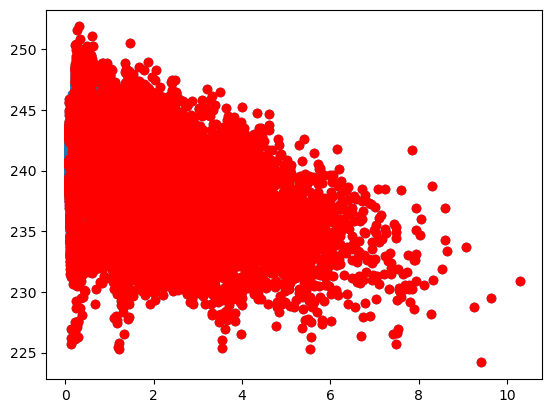

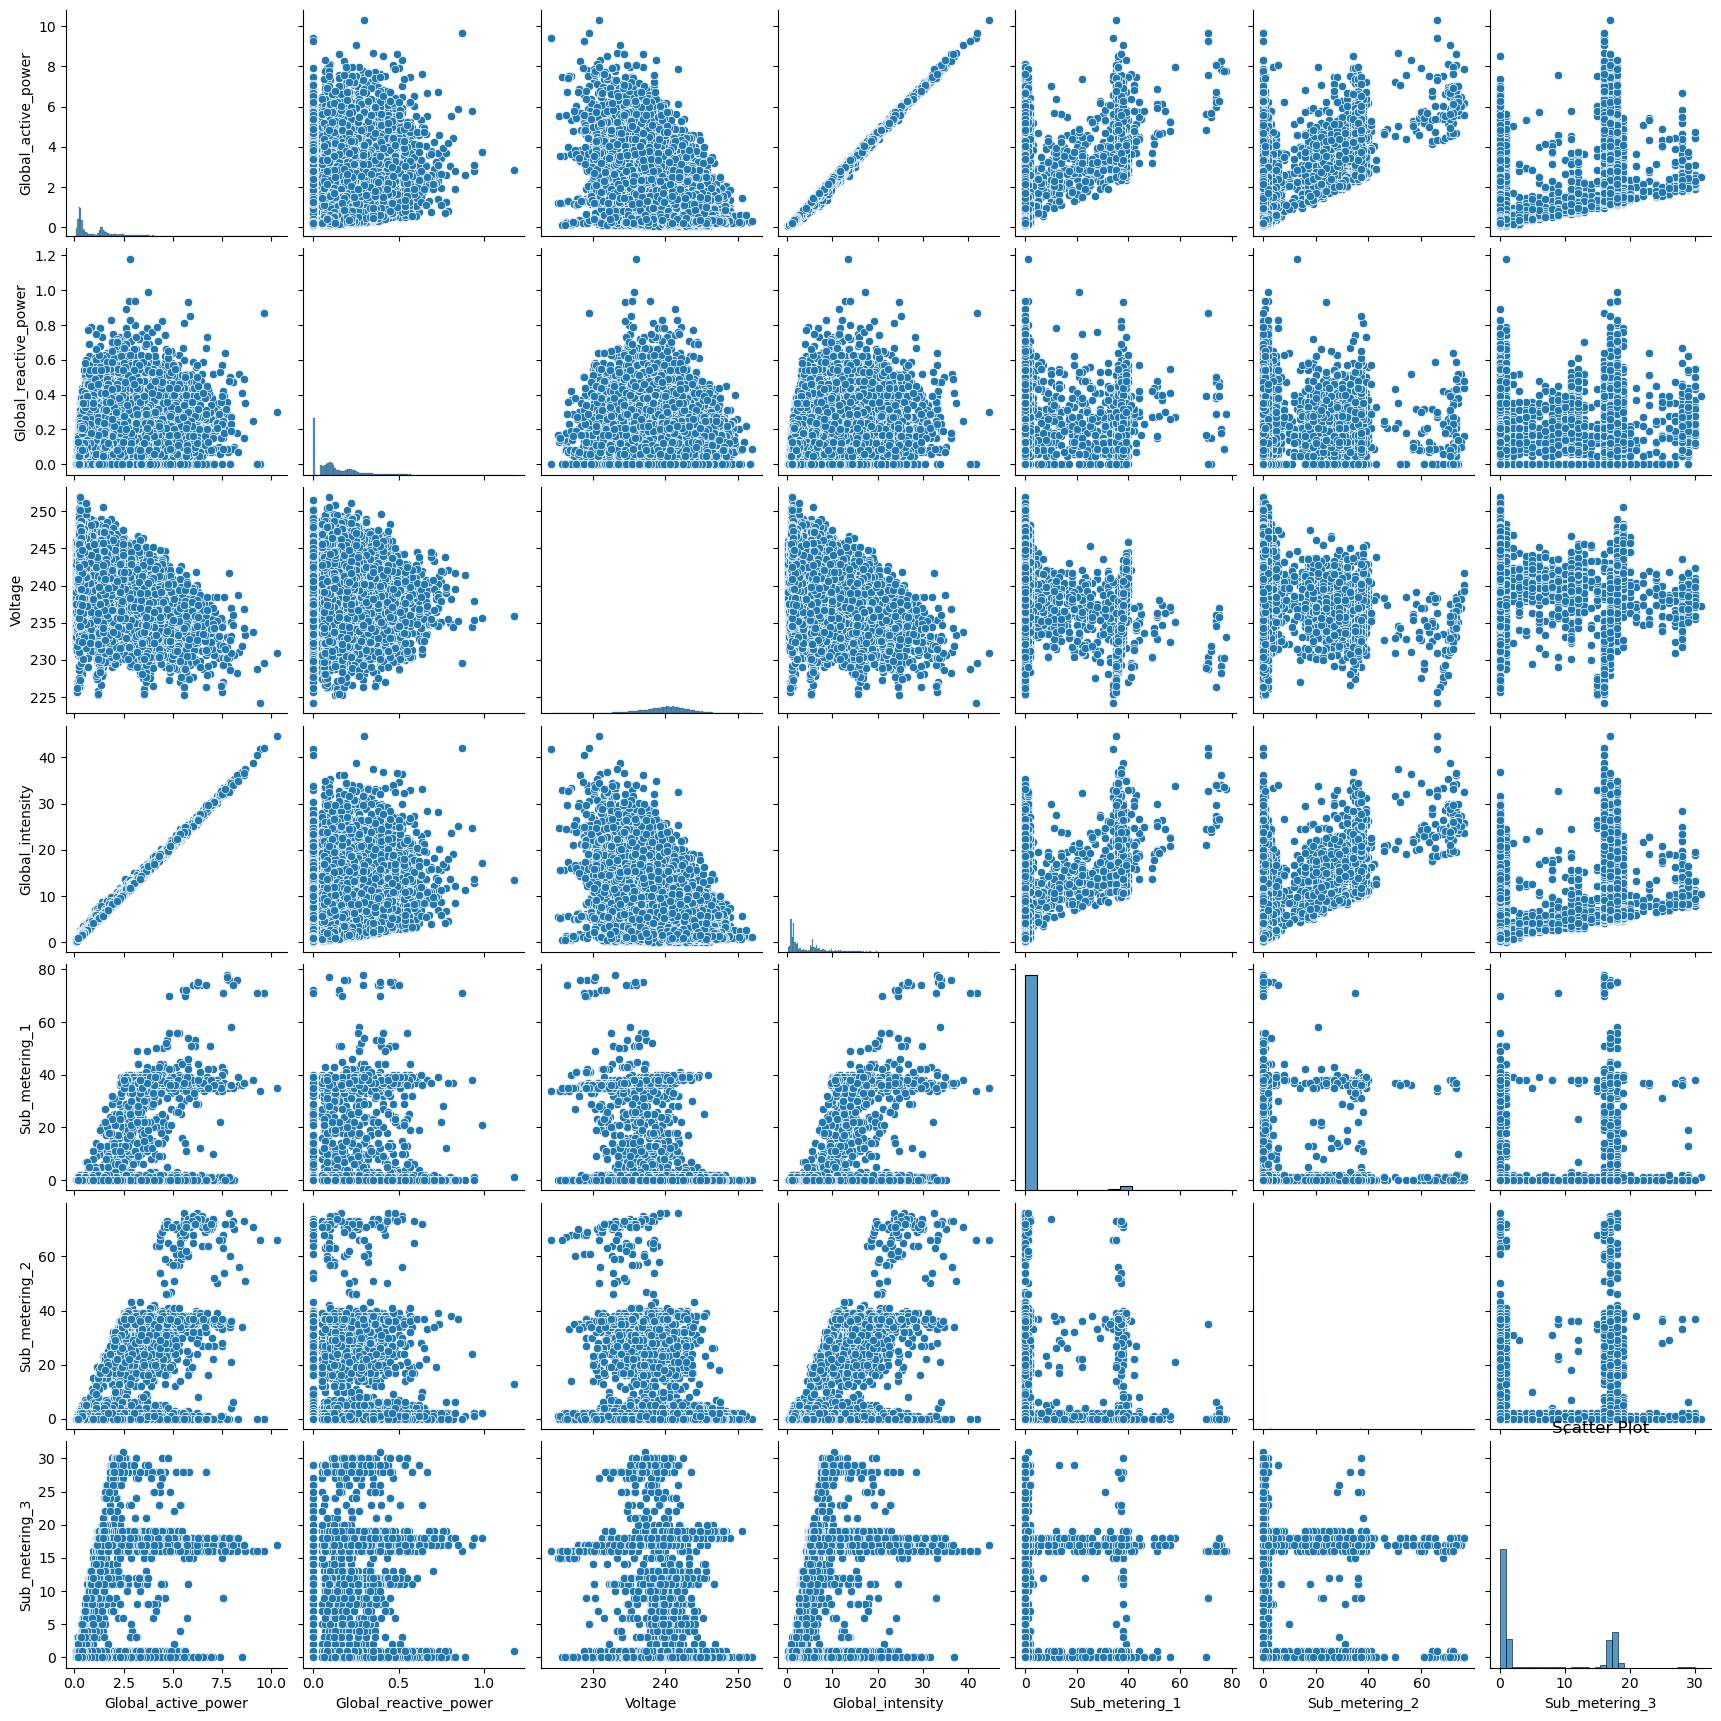

              precision    recall  f1-score   support

           0       0.60      0.87      0.71      2806
           1       0.94      0.78      0.85      7154

    accuracy                           0.80      9960
   macro avg       0.77      0.82      0.78      9960
weighted avg       0.84      0.80      0.81      9960



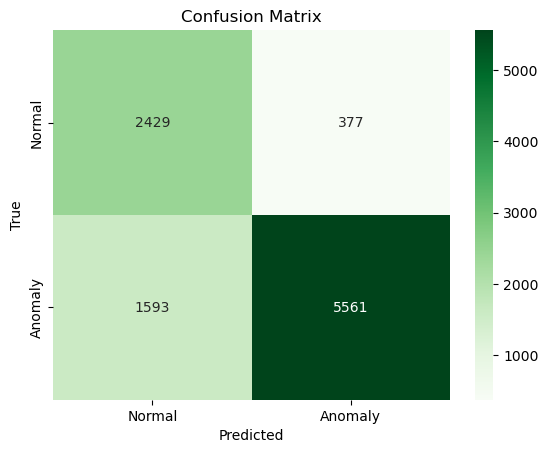

Precision: 0.80
Recall: 0.80
F1 Score: 0.80


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif

def anomaly_detection_svm():
    
    # Load dataset
    data1 = pd.read_csv('pow_cons.csv')
    
    
    data = data1.sample(n=50000, random_state=5)
    
    data = data.drop(['Date','Time'], axis=1)
    data.info()
    
    data.dropna(axis=0, inplace=True)
    
#     X = data.drop('Global_active_power', axis=1)  # Assuming 'target' is the column name of the continuous target variable
#     y_cont = data['Global_active_power']
    
    #convert all the values in the columns into numeric
    for column in data.columns:
        data[column] = pd.to_numeric(data[column], errors='coerce')


    model = OneClassSVM(kernel='rbf', gamma='auto', nu = 0.2).fit(data)
    y_pred = model.predict(data)

    anomaly_values = data.iloc[np.where(y_pred ==-1)]


    plt.scatter(data["Global_active_power"], data["Voltage"])
    plt.scatter(anomaly_values["Global_active_power"],anomaly_values["Voltage"], c="r")
    plt.show()
    
    sns.pairplot(data, kind='scatter')
    plt.title('Scatter Plot')
    plt.show()
    
    X = data.drop('Global_active_power', axis=1)  # Assuming 'label' is your target column
    y_cont = data['Global_active_power']

#     # First, binarize `y` based on a chosen threshold.
    y = np.where(y_cont > .3, 1, 0)  # Define `threshold` based on your domain knowledge

    # # Convert continuous target variable to binary labels
    # y = np.where((y_train < 1) | (y_train > 8), 1, 0)

#     # Bin the continuous target variable
#     binner = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
#     y = binner.fit_transform(y_cont.values.reshape(-1, 1)).flatten()

#     # Select top k features; k might be adjusted based on the dataset
#     selector = SelectKBest(f_classif, k=3)
#     X_selected = selector.fit_transform(X, y)
    
    
    
    # Select top k features; you might adjust k based on your dataset
    selector = SelectKBest(f_classif, k=3)
    X_selected = selector.fit_transform(X, y)
    
    X_selected
    
    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=5)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train One-Class SVM
    clf = OneClassSVM(nu=0.1, kernel='rbf', gamma='auto')
    clf.fit(X_train_scaled[y_train == 0])  # Assuming 0 is the label for normal data
    
    # Predict
    y_pred = clf.predict(X_test_scaled)
    y_pred = np.where(y_pred == 1, 0, 1)  # Convert predictions: -1 to 1 for anomalies, 1 to 0 for normal
    
    # Evaluate
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix Visualization
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Evaluate the SVM model
    precision = precision_score(y_test, y_pred, average='micro')
    recall = recall_score(y_test, y_pred, average='micro')
    f1 = f1_score(y_test, y_pred, average='micro')
    conf_matrix = confusion_matrix(y_test, y_pred)
    
     # Print the evaluation metrics
    print("Precision: {:.2f}".format(precision))
    print("Recall: {:.2f}".format(recall))
    print("F1 Score: {:.2f}".format(f1))

# Example usage
anomaly_detection_svm()
